# Visualizing a CNN with CIFAR10

Below is the code organizied in a Jupyter notebook for training a Lenet5-like model on the dataset.

In [1]:
import os
import math
from scipy import misc
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import matplotlib as mp

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(x): return x
    print("Install tqdm for cool progress bars")

cwd = os.getcwd()

In [2]:
# --------------------------------------------------
# net setup


def weight_variable(shape):
    '''
    Initialize weights
    :param shape: shape of weights, e.g. [w, h ,Cin, Cout] where
    w: width of the filters
    h: height of the filters
    Cin: the number of the channels of the filters
    Cout: the number of filters
    :return: a tensor variable for weights with initial values
    '''

    # IMPLEMENT YOUR WEIGHT_VARIABLE HERE
    W = tf.Variable(tf.truncated_normal(shape, stddev=0.1))
    return W


def bias_variable(shape):
    '''
    Initialize biases
    :param shape: shape of biases, e.g. [Cout] where
    Cout: the number of filters
    :return: a tensor variable for biases with initial values
    '''

    # IMPLEMENT YOUR BIAS_VARIABLE HERE
    b = tf.Variable(tf.constant(0.0, shape=shape))
    return b


def conv2d(x, W):
    '''
    Perform 2-D convolution
    :param x: input tensor of size [N, W, H, Cin] where
    N: the number of images
    W: width of images
    H: height of images
    Cin: the number of channels of images
    :param W: weight tensor [w, h, Cin, Cout]
    w: width of the filters
    h: height of the filters
    Cin: the number of the channels of the filters = the number of channels of images
    Cout: the number of filters
    :return: a tensor of features extracted by the filters, a.k.a. the results after convolution
    '''

    # IMPLEMENT YOUR CONV2D HERE
    h_conv = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
    return h_conv


def max_pool_2x2(x):
    '''
    Perform non-overlapping 2-D maxpooling on 2x2 regions in the input data
    :param x: input data
    :return: the results of maxpooling (max-marginalized + downsampling)
    '''

    # IMPLEMENT YOUR MAX_POOL_2X2 HERE
    h_max = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                           padding='SAME')
    return h_max


In [3]:
# Some logging stuff

def variable_summary(name, tensor):
    with tf.name_scope(name + "-summary"):
        # Summarize the basic scalar stats
        mean, variance = tf.nn.moments(
            tensor, axes=list(range(tf.rank(tensor).eval())))
        tf.summary.scalar('mean', mean)
        tf.summary.scalar('std', tf.sqrt(variance))
        tf.summary.scalar('max', tf.reduce_max(tensor))
        tf.summary.scalar('min', tf.reduce_min(tensor))
        # Create a histogram of the tensor
        tf.summary.histogram('histogram', tensor)


def plot_filter(filters, name):
    n_filters = filters.shape[3]
    plt.figure(1, figsize=(20, 20))
    n_columns = 6
    n_rows = math.ceil(n_filters / n_columns) + 1
    plt.title(name)
    for i in range(n_filters):
        plt.subplot(n_rows, n_columns, i + 1)
        plt.title('Filter ' + str(i))
        plt.imshow(filters[0, :, :, i], cmap="gray")
    plt.show()


def get_filters(layer, inp_image, name):
    filters = sess.run(layer, feed_dict={
        x: inp_image[np.newaxis, ...], keep_prob: 1.0, conv_keep_prob: 1.0})
    plot_filter(filters, name)
    
class MaxCheckpointer(object):

    def __init__(self, save_to, sess):
        self.cur_max = -float('inf')
        # Create a saver for writing training checkpoints.
        self.saver = tf.train.Saver()
        self.save_to = save_to

    def __call__(self, new_val):
        if new_val >= self.cur_max:
            print("Got new best:", new_val, "- saving model.")
            self.saver.save(sess, os.path.join(cwd, self.save_to))
            self.cur_max = new_val

In [4]:
# Data loading and some globals

ntrain = 1000  # per class
ntest = 100  # per class
nclass = 10  # number of classes
imsize = 28
nchannels = 1
batchsize = 128
nepochs = 50

Train = np.zeros((ntrain * nclass, imsize, imsize, nchannels))
Test = np.zeros((ntest * nclass, imsize, imsize, nchannels))
LTrain = np.zeros((ntrain * nclass, nclass))
LTest = np.zeros((ntest * nclass, nclass))

itrain = -1
itest = -1
for iclass in range(0, nclass):
    for isample in range(0, ntrain):
        path = os.path.join(
            cwd, 'CIFAR10/Train/%d/Image%05d.png' % (iclass, isample))
        im = misc.imread(path)  # 28 by 28
        im = im.astype(float) / 255
        itrain += 1
        Train[itrain, :, :, 0] = im
        LTrain[itrain, iclass] = 1  # 1-hot lable
    for isample in range(0, ntest):
        path = os.path.join(
            cwd, 'CIFAR10/Test/%d/Image%05d.png' % (iclass, isample))
        im = misc.imread(path)  # 28 by 28
        im = im.astype(float) / 255
        itest += 1
        Test[itest, :, :, 0] = im
        LTest[itest, iclass] = 1  # 1-hot lable

sess = tf.InteractiveSession()

# tf variable for the data, remember shape is [None, width, height, numberOfChannels]
tf_data = tf.placeholder(tf.float32, shape=[None, imsize, imsize, nchannels])
# tf variable for labels
tf_labels = tf.placeholder(tf.float32, shape=[None, nclass])

In [5]:
# --------------------------------------------------
# model
# create your model
# First convolutional layer
conv_keep_prob = tf.placeholder(tf.float32)

x = tf_data
# x = tf.nn.dropout(x, conv_keep_prob)

W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# Variable summaries
variable_summary("W_conv1", W_conv1)
variable_summary("b_conv1", b_conv1)
variable_summary("h_conv1", h_conv1)
variable_summary("h_pool1", h_pool1)

h_pool1_drop = tf.nn.dropout(h_pool1, conv_keep_prob)

# Second convolutional layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1_drop, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# Variable summaries
variable_summary("W_conv2", W_conv2)
variable_summary("b_conv2", b_conv2)
variable_summary("h_conv2", h_conv2)
variable_summary("h_pool2", h_pool2)

h_pool2_drop = tf.nn.dropout(h_pool2, conv_keep_prob)

# W_conv3 = weight_variable([5, 5, 64, 128])
# b_conv3 = bias_variable([128])
# h_conv3 = tf.nn.relu(conv2d(h_pool2_drop, W_conv3) + b_conv3)
# h_pool3 = max_pool_2x2(h_conv3)

conv_out = h_pool2_drop

# Densely connected layer
conv_out_shape = conv_out.get_shape().as_list()
flat_shape = conv_out_shape[1] * conv_out_shape[2] * conv_out_shape[3]
flat_conv = tf.reshape(
    conv_out, [-1, flat_shape])

# dropout
keep_prob = tf.placeholder(tf.float32)
flat_conv_drop = tf.nn.dropout(flat_conv, keep_prob)

# softmax
W_fc2 = weight_variable([flat_shape, 10])
b_fc2 = bias_variable([10])
y_conv = tf.matmul(flat_conv_drop, W_fc2) + b_fc2

# Variable summaries
variable_summary("W_fc2", W_fc2)
variable_summary("b_fc2", b_fc2)
variable_summary("y_conv", y_conv)

## Hyperparameter Search

To find a good model, I searched through the following options:
- learning rate: 1e-2, 1e-3, 1e-4
- with and without fully connected layer before softmax layer
- with and without dropout on the convolutional layers
- 3x3 convolutions vs 5x5 convolutions
- an extra convolutional layer
- adding global average pooling at the end of conv layers

After searching through all these options, I achieved the best model I was able to achieve within 50 epochs is the one above

In [6]:
# --------------------------------------------------
# loss
# set up the loss, optimization, evaluation, and accuracy
# setup training
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_labels, logits=y_conv))
opt = tf.train.AdamOptimizer(1e-3)
optimizer = opt.minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(tf_labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

tf.summary.scalar("Loss", cross_entropy)
tf.summary.scalar("Accuracy", accuracy)

<tf.Tensor 'Accuracy:0' shape=() dtype=string>

In [7]:
# --------------------------------------------------
# optimization
sess.run(tf.global_variables_initializer())
# Set up the summary writer
result_dir = os.path.join(cwd, "results")
summary_op = tf.summary.merge_all()
summary_writer = tf.summary.FileWriter(result_dir, sess.graph)
# Create model checkpointer
checkpointer = MaxCheckpointer("cifar10-best", sess)

# setup as [batchsize, width, height, numberOfChannels] and use np.zeros()
batch_xs = np.empty((batchsize, imsize, imsize, nchannels))
# setup as [batchsize, the how many classes]
batch_ys = np.zeros((batchsize, nclass))
nsamples = ntrain * nclass
# batch indicies
perm = np.arange(nsamples)
# try a small iteration size once it works then continue
for i in range(nepochs):
    print("Epoch {}/{}".format(i + 1, nepochs))
    train_ep_acc_sum = 0
    # Shuffle the indicies
    np.random.shuffle(perm)
    for j in tqdm(range(0, nsamples, batchsize)):
        batch_xs = Train[perm[j:j + batchsize]]
        batch_ys = LTrain[perm[j:j + batchsize]]
        # output the training accuracy every 100 iterations
        train_accuracy = accuracy.eval(feed_dict={
            tf_data: batch_xs, tf_labels: batch_ys, keep_prob: 1.0, conv_keep_prob: 1.0})
        train_ep_acc_sum += (train_accuracy * len(batch_xs))
        # Collect the summary statistics
        summary_str = sess.run(summary_op, feed_dict={
                               tf_data: batch_xs, tf_labels: batch_ys, keep_prob: 1.0, conv_keep_prob: 1.0})
        summary_writer.add_summary(summary_str, i + j / nsamples)
        summary_writer.flush()
        # dropout only during training
        optimizer.run(feed_dict={
            tf_data: batch_xs, tf_labels: batch_ys, keep_prob: 0.5, conv_keep_prob: 0.75})
    print("Train Accuracy: {}".format(train_ep_acc_sum / nsamples))
    test_acc = accuracy.eval(
        feed_dict={tf_data: Test, tf_labels: LTest, keep_prob: 1.0, conv_keep_prob: 1.0})
    # Collect the summary statistics on test data
    summary_str = sess.run(summary_op, feed_dict={
                           tf_data: Test, tf_labels: LTest, keep_prob: 1.0, conv_keep_prob: 1.0})
    summary_writer.add_summary(summary_str, i)
    summary_writer.flush()
    print("Test accuracy %g" % test_acc)
    checkpointer(test_acc)

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/50


100%|██████████| 79/79 [00:12<00:00,  6.20it/s]


Train Accuracy: 0.1219


  1%|▏         | 1/79 [00:00<00:11,  6.65it/s]

Test accuracy 0.16
Got new best: 0.16 - saving model.
Epoch 2/50


100%|██████████| 79/79 [00:11<00:00,  6.74it/s]


Train Accuracy: 0.1853


  1%|▏         | 1/79 [00:00<00:11,  6.73it/s]

Test accuracy 0.21
Got new best: 0.21 - saving model.
Epoch 3/50


100%|██████████| 79/79 [00:11<00:00,  6.76it/s]


Train Accuracy: 0.2709


  1%|▏         | 1/79 [00:00<00:11,  6.83it/s]

Test accuracy 0.294
Got new best: 0.294 - saving model.
Epoch 4/50


100%|██████████| 79/79 [00:12<00:00,  6.49it/s]


Train Accuracy: 0.3307


  1%|▏         | 1/79 [00:00<00:12,  6.29it/s]

Test accuracy 0.324
Got new best: 0.324 - saving model.
Epoch 5/50


100%|██████████| 79/79 [00:12<00:00,  6.55it/s]


Train Accuracy: 0.3743


  1%|▏         | 1/79 [00:00<00:11,  6.91it/s]

Test accuracy 0.383
Got new best: 0.383 - saving model.
Epoch 6/50


100%|██████████| 79/79 [00:11<00:00,  6.81it/s]


Train Accuracy: 0.4036


  1%|▏         | 1/79 [00:00<00:12,  6.30it/s]

Test accuracy 0.404
Got new best: 0.404 - saving model.
Epoch 7/50


100%|██████████| 79/79 [00:11<00:00,  6.90it/s]


Train Accuracy: 0.4268


  1%|▏         | 1/79 [00:00<00:12,  6.44it/s]

Test accuracy 0.439
Got new best: 0.439 - saving model.
Epoch 8/50


100%|██████████| 79/79 [00:11<00:00,  6.89it/s]


Train Accuracy: 0.4444


  1%|▏         | 1/79 [00:00<00:11,  6.77it/s]

Test accuracy 0.433
Epoch 9/50


100%|██████████| 79/79 [00:11<00:00,  6.87it/s]


Train Accuracy: 0.4626


  1%|▏         | 1/79 [00:00<00:11,  7.05it/s]

Test accuracy 0.439
Got new best: 0.439 - saving model.
Epoch 10/50


100%|██████████| 79/79 [00:11<00:00,  7.02it/s]


Train Accuracy: 0.478


  1%|▏         | 1/79 [00:00<00:12,  6.40it/s]

Test accuracy 0.469
Got new best: 0.469 - saving model.
Epoch 11/50


100%|██████████| 79/79 [00:11<00:00,  6.93it/s]


Train Accuracy: 0.4914


  1%|▏         | 1/79 [00:00<00:10,  7.22it/s]

Test accuracy 0.455
Epoch 12/50


100%|██████████| 79/79 [00:11<00:00,  6.99it/s]


Train Accuracy: 0.5056


  1%|▏         | 1/79 [00:00<00:10,  7.19it/s]

Test accuracy 0.474
Got new best: 0.474 - saving model.
Epoch 13/50


100%|██████████| 79/79 [00:11<00:00,  7.00it/s]


Train Accuracy: 0.5132


  1%|▏         | 1/79 [00:00<00:11,  6.58it/s]

Test accuracy 0.489
Got new best: 0.489 - saving model.
Epoch 14/50


100%|██████████| 79/79 [00:11<00:00,  7.05it/s]


Train Accuracy: 0.5261


  1%|▏         | 1/79 [00:00<00:12,  6.12it/s]

Test accuracy 0.475
Epoch 15/50


100%|██████████| 79/79 [00:12<00:00,  6.08it/s]


Train Accuracy: 0.535


  0%|          | 0/79 [00:00<?, ?it/s]

Test accuracy 0.493
Got new best: 0.493 - saving model.
Epoch 16/50


100%|██████████| 79/79 [00:14<00:00,  5.47it/s]


Train Accuracy: 0.5394


  1%|▏         | 1/79 [00:00<00:10,  7.15it/s]

Test accuracy 0.517
Got new best: 0.517 - saving model.
Epoch 17/50


100%|██████████| 79/79 [00:11<00:00,  7.15it/s]


Train Accuracy: 0.5556


  1%|▏         | 1/79 [00:00<00:10,  7.31it/s]

Test accuracy 0.513
Epoch 18/50


100%|██████████| 79/79 [00:11<00:00,  7.14it/s]


Train Accuracy: 0.5599


  1%|▏         | 1/79 [00:00<00:11,  7.08it/s]

Test accuracy 0.505
Epoch 19/50


100%|██████████| 79/79 [00:11<00:00,  7.15it/s]


Train Accuracy: 0.5711


  1%|▏         | 1/79 [00:00<00:11,  7.07it/s]

Test accuracy 0.506
Epoch 20/50


100%|██████████| 79/79 [00:10<00:00,  7.20it/s]


Train Accuracy: 0.5774


  0%|          | 0/79 [00:00<?, ?it/s]

Test accuracy 0.526
Got new best: 0.526 - saving model.
Epoch 21/50


100%|██████████| 79/79 [00:12<00:00,  6.25it/s]


Train Accuracy: 0.5855


  1%|▏         | 1/79 [00:00<00:10,  7.26it/s]

Test accuracy 0.511
Epoch 22/50


100%|██████████| 79/79 [00:11<00:00,  7.12it/s]


Train Accuracy: 0.5972


  1%|▏         | 1/79 [00:00<00:10,  7.12it/s]

Test accuracy 0.533
Got new best: 0.533 - saving model.
Epoch 23/50


100%|██████████| 79/79 [00:11<00:00,  6.83it/s]


Train Accuracy: 0.603


  1%|▏         | 1/79 [00:00<00:11,  6.64it/s]

Test accuracy 0.537
Got new best: 0.537 - saving model.
Epoch 24/50


100%|██████████| 79/79 [00:11<00:00,  7.03it/s]


Train Accuracy: 0.6173


  1%|▏         | 1/79 [00:00<00:11,  7.05it/s]

Test accuracy 0.539
Got new best: 0.539 - saving model.
Epoch 25/50


100%|██████████| 79/79 [00:11<00:00,  7.04it/s]


Train Accuracy: 0.6174


  1%|▏         | 1/79 [00:00<00:11,  6.94it/s]

Test accuracy 0.546
Got new best: 0.546 - saving model.
Epoch 26/50


100%|██████████| 79/79 [00:11<00:00,  7.02it/s]


Train Accuracy: 0.6275


  1%|▏         | 1/79 [00:00<00:11,  6.65it/s]

Test accuracy 0.54
Epoch 27/50


100%|██████████| 79/79 [00:11<00:00,  7.02it/s]


Train Accuracy: 0.634


  0%|          | 0/79 [00:00<?, ?it/s]

Test accuracy 0.557
Got new best: 0.557 - saving model.
Epoch 28/50


100%|██████████| 79/79 [00:12<00:00,  6.16it/s]


Train Accuracy: 0.6456


  1%|▏         | 1/79 [00:00<00:12,  6.23it/s]

Test accuracy 0.551
Epoch 29/50


100%|██████████| 79/79 [00:12<00:00,  6.38it/s]


Train Accuracy: 0.6499


  1%|▏         | 1/79 [00:00<00:13,  5.70it/s]

Test accuracy 0.548
Epoch 30/50


100%|██████████| 79/79 [00:11<00:00,  6.77it/s]


Train Accuracy: 0.6536


  1%|▏         | 1/79 [00:00<00:11,  6.98it/s]

Test accuracy 0.565
Got new best: 0.565 - saving model.
Epoch 31/50


100%|██████████| 79/79 [00:11<00:00,  6.96it/s]


Train Accuracy: 0.6635


  1%|▏         | 1/79 [00:00<00:12,  6.33it/s]

Test accuracy 0.574
Got new best: 0.574 - saving model.
Epoch 32/50


100%|██████████| 79/79 [00:12<00:00,  6.48it/s]


Train Accuracy: 0.6657


  1%|▏         | 1/79 [00:00<00:11,  6.60it/s]

Test accuracy 0.572
Epoch 33/50


100%|██████████| 79/79 [00:11<00:00,  6.71it/s]


Train Accuracy: 0.6693


  1%|▏         | 1/79 [00:00<00:11,  6.62it/s]

Test accuracy 0.563
Epoch 34/50


100%|██████████| 79/79 [00:12<00:00,  6.48it/s]


Train Accuracy: 0.6709


  0%|          | 0/79 [00:00<?, ?it/s]

Test accuracy 0.58
Got new best: 0.58 - saving model.
Epoch 35/50


100%|██████████| 79/79 [00:12<00:00,  6.54it/s]


Train Accuracy: 0.6816


  1%|▏         | 1/79 [00:00<00:10,  7.12it/s]

Test accuracy 0.584
Got new best: 0.584 - saving model.
Epoch 36/50


100%|██████████| 79/79 [00:11<00:00,  6.85it/s]


Train Accuracy: 0.6828


  1%|▏         | 1/79 [00:00<00:11,  6.62it/s]

Test accuracy 0.586
Got new best: 0.586 - saving model.
Epoch 37/50


100%|██████████| 79/79 [00:12<00:00,  6.43it/s]


Train Accuracy: 0.6878


  1%|▏         | 1/79 [00:00<00:11,  6.68it/s]

Test accuracy 0.583
Epoch 38/50


100%|██████████| 79/79 [00:12<00:00,  6.20it/s]


Train Accuracy: 0.7009


  1%|▏         | 1/79 [00:00<00:12,  6.28it/s]

Test accuracy 0.579
Epoch 39/50


100%|██████████| 79/79 [00:11<00:00,  6.59it/s]


Train Accuracy: 0.6992


  1%|▏         | 1/79 [00:00<00:10,  7.11it/s]

Test accuracy 0.564
Epoch 40/50


100%|██████████| 79/79 [00:12<00:00,  6.56it/s]


Train Accuracy: 0.6979


  1%|▏         | 1/79 [00:00<00:11,  7.05it/s]

Test accuracy 0.584
Epoch 41/50


100%|██████████| 79/79 [00:11<00:00,  6.64it/s]


Train Accuracy: 0.7087


  0%|          | 0/79 [00:00<?, ?it/s]

Test accuracy 0.591
Got new best: 0.591 - saving model.
Epoch 42/50


100%|██████████| 79/79 [00:12<00:00,  6.55it/s]


Train Accuracy: 0.7122


  0%|          | 0/79 [00:00<?, ?it/s]

Test accuracy 0.599
Got new best: 0.599 - saving model.
Epoch 43/50


100%|██████████| 79/79 [00:11<00:00,  6.89it/s]


Train Accuracy: 0.7164


  1%|▏         | 1/79 [00:00<00:10,  7.21it/s]

Test accuracy 0.585
Epoch 44/50


100%|██████████| 79/79 [00:11<00:00,  6.64it/s]


Train Accuracy: 0.7168


  1%|▏         | 1/79 [00:00<00:11,  6.92it/s]

Test accuracy 0.576
Epoch 45/50


100%|██████████| 79/79 [00:11<00:00,  6.85it/s]


Train Accuracy: 0.7237


  1%|▏         | 1/79 [00:00<00:11,  6.62it/s]

Test accuracy 0.593
Epoch 46/50


100%|██████████| 79/79 [00:11<00:00,  7.17it/s]


Train Accuracy: 0.724


  1%|▏         | 1/79 [00:00<00:11,  6.53it/s]

Test accuracy 0.589
Epoch 47/50


100%|██████████| 79/79 [00:12<00:00,  6.50it/s]


Train Accuracy: 0.7306


  1%|▏         | 1/79 [00:00<00:12,  6.45it/s]

Test accuracy 0.594
Epoch 48/50


100%|██████████| 79/79 [00:12<00:00,  6.49it/s]


Train Accuracy: 0.7376


  0%|          | 0/79 [00:00<?, ?it/s]

Test accuracy 0.606
Got new best: 0.606 - saving model.
Epoch 49/50


100%|██████████| 79/79 [00:11<00:00,  6.58it/s]


Train Accuracy: 0.7432


  0%|          | 0/79 [00:00<?, ?it/s]

Test accuracy 0.608
Got new best: 0.608 - saving model.
Epoch 50/50


100%|██████████| 79/79 [00:11<00:00,  6.73it/s]


Train Accuracy: 0.7475
Test accuracy 0.584


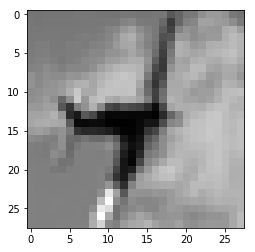

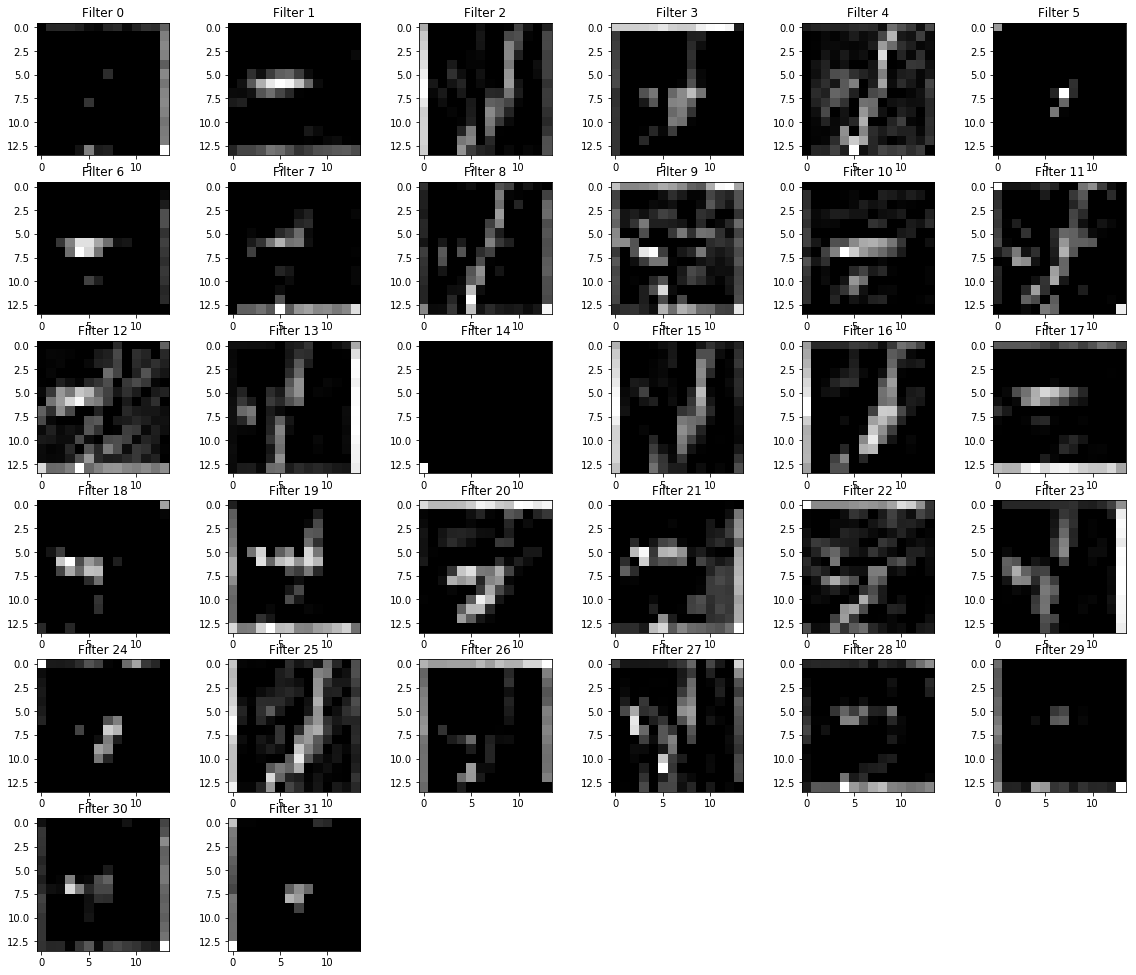

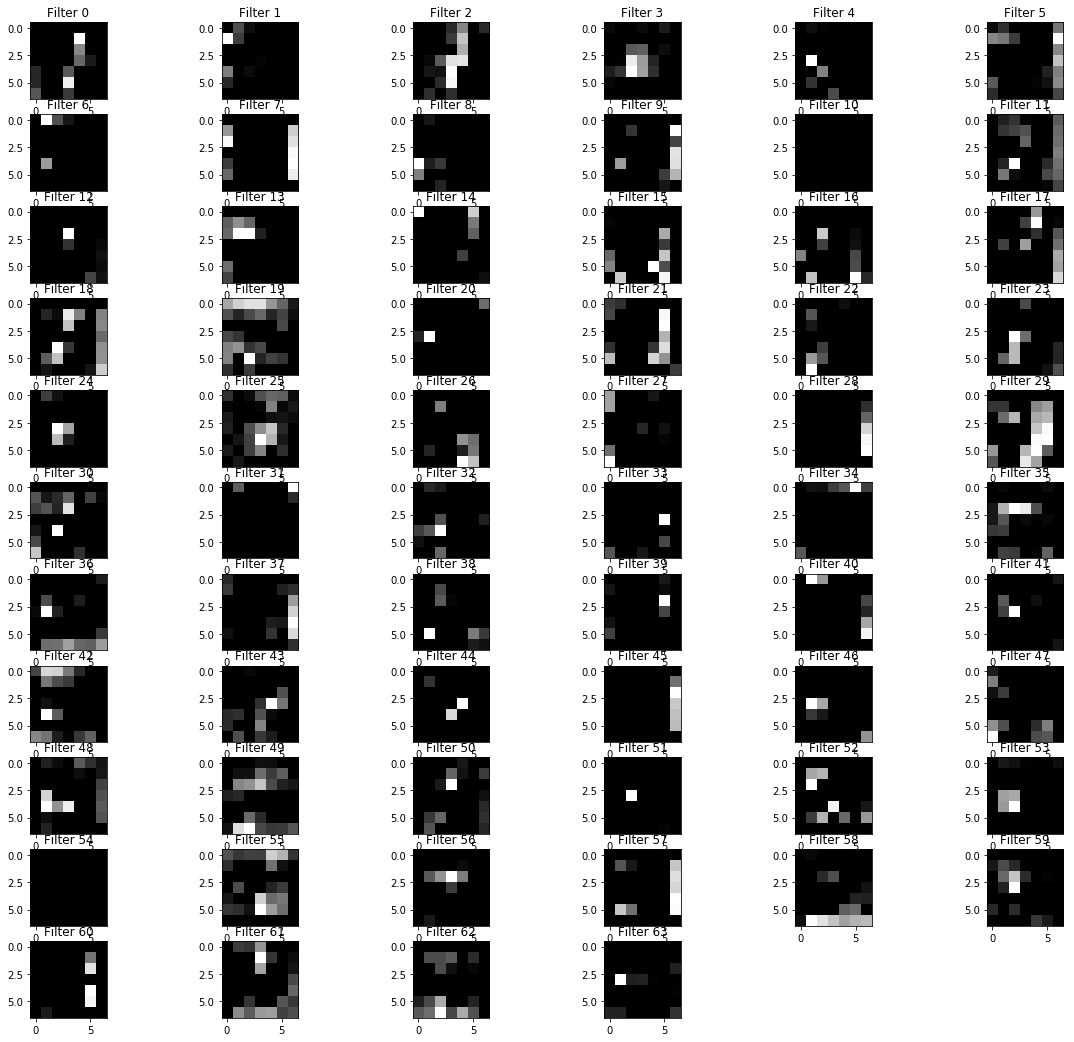

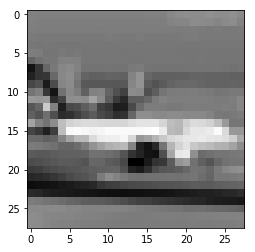

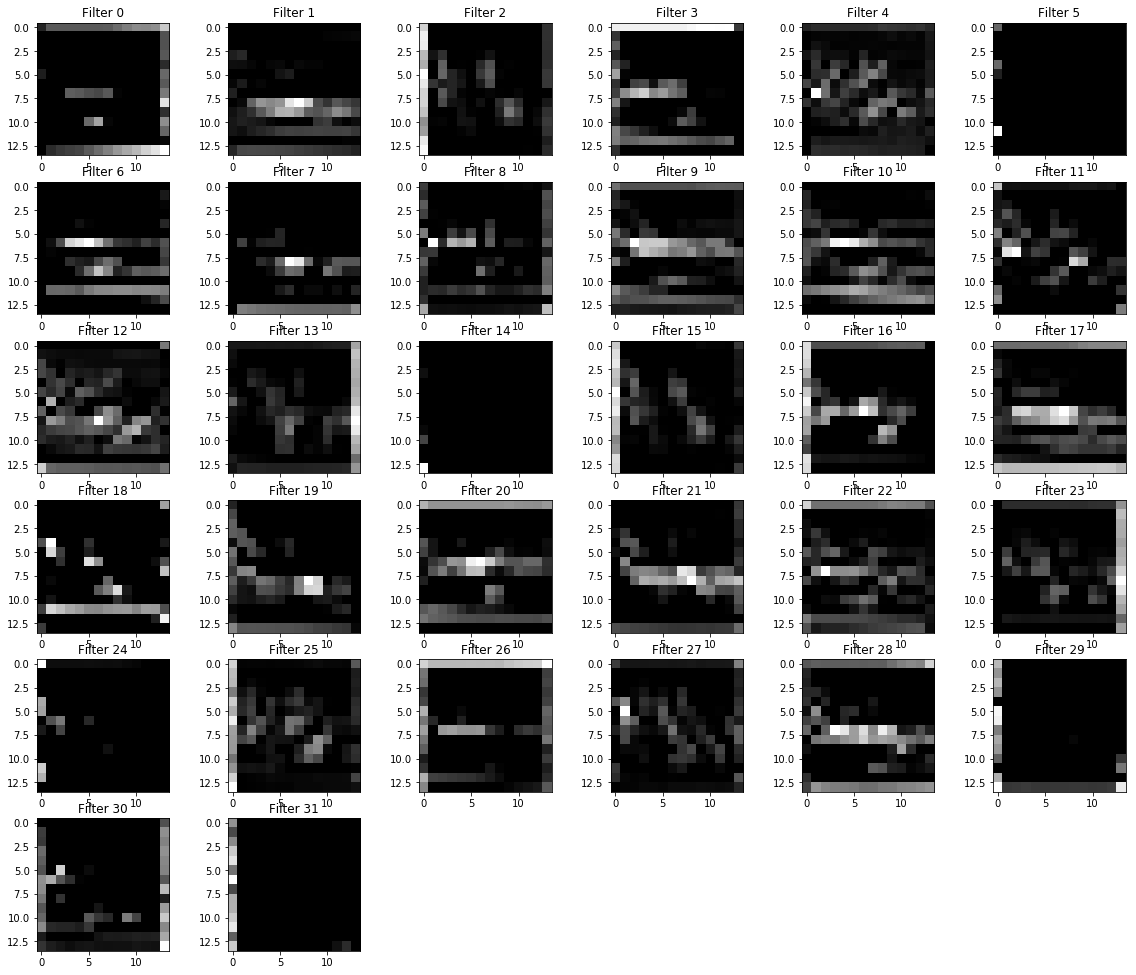

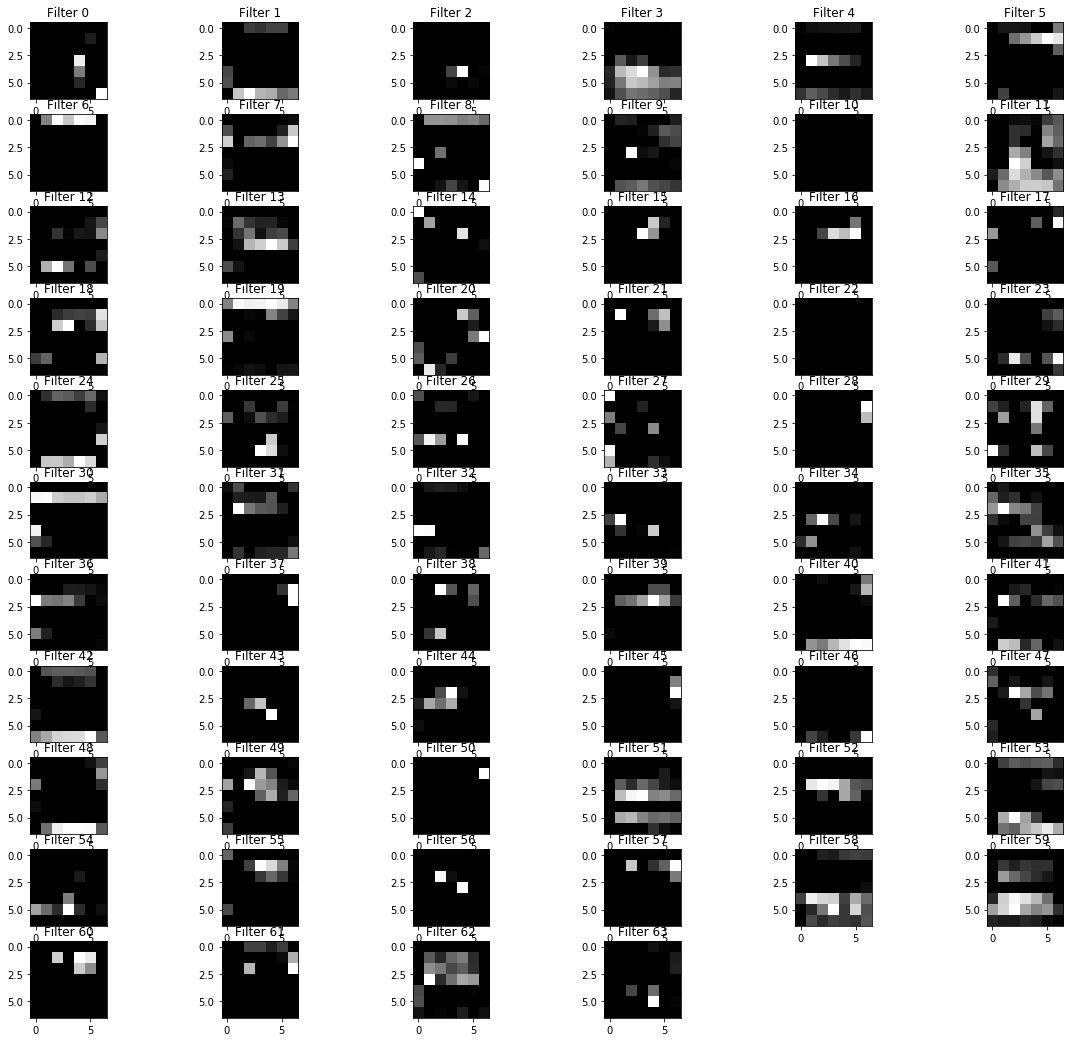

In [8]:
# Select 2 images to visualize through the convnet
vis_inps = 2
for i in np.random.permutation(ntest)[:2]:
    # Show the image
    plt.imshow(Test[i,...,0], cmap="gray")
    plt.show()
    get_filters(h_pool1, Test[i], "Conv1")
    get_filters(h_pool2, Test[i], "Conv2")

## Summaries Statistics of the ConvNet

### Net Weight and Activation Histograms

<img src="ScalarStats1.png">

<img src="ScalarStats2.png">

<img src="ScalarStats3.png">

<img src="ScalarStats4.png">

<img src="ConvHistograms.png">

In [9]:
# Close the session
sess.close()

## Visualizing and Understanding Convolutional Networks

Summary of "Visualizing and Understanding Convolutional Networks"

The paper discusses a new technique to analyze learned filters in deep convolutional neural networks. They discuss how there has previously been little understanding of what kind of features and invariances are learnied in these deep models and how they could be improved. The novel technique involves the use of their "Deconvolutional Network (deconvnet)" made of unpooling, rectification, and transposed filtering repurposed from deep ImageNet models. Using this technique, the authors of the paper are able to produce insightful visualizations of not only lower layers, but also the deeper layers. Using these methods, they created an Imagenet model that generalizes well to other datasets.

# Build and Train an RNN on MNIST

In [1]:
# Setup
import tensorflow as tf
from tensorflow.python.ops import rnn, rnn_cell
import numpy as np


from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib import rnn

Playing with the different hyperparameters, I found these to be the best.

In [2]:
# Data loading and initializations
mnist = input_data.read_data_sets(
    'MNIST_data', one_hot=True)  # call mnist function

learningRate = 1e-3
trainingIters = 120000
batchSize = 128
displayStep = 10

nInput = 28  # we want the input to take the 28 pixels
nSteps = 28  # every 28
nHidden = 256  # number of neurons for the RNN
nClasses = 10  # this is MNIST so you know

x = tf.placeholder('float', [None, nSteps, nInput])
y = tf.placeholder('float', [None, nClasses])

weights = {
    'out': tf.Variable(tf.random_normal([nHidden, nClasses]))
}

biases = {
    'out': tf.Variable(tf.random_normal([nClasses]))
}

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
# Setup the RNN
def RNN(x, weights, biases, use_gru=False):
    # configuring so you can get it as needed for the 28 pixels
    x = tf.unstack(x, nSteps, 1)

    # find which lstm to use in the documentation
    lstmCell = rnn.BasicLSTMCell(
        nHidden) if not use_gru else rnn.GRUCell(nHidden)

    # for the rnn where to get the output and hidden state
    outputs, states = tf.nn.static_rnn(lstmCell, x, dtype=tf.float32)

    return tf.matmul(outputs[-1], weights['out']) + biases['out']

In [4]:
# Create the RNN with an LSTM
pred = RNN(x, weights, biases, use_gru=False)

In [6]:
# optimization
# create the cost, optimization, evaluation, and accuracy
# for the cost softmax_cross_entropy_with_logits seems really good
cost = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred))
optimizer = tf.train.AdamOptimizer(
    learning_rate=learningRate).minimize(cost)

correctPred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

In [7]:
init = tf.global_variables_initializer()

# Train the rnn
with tf.Session() as sess:
    sess.run(init)
    step = 1

    while step * batchSize < trainingIters:
        # mnist has a way to get the next batch
        batchX, batchY = mnist.train.next_batch(batchSize)
        batchX = batchX.reshape((batchSize, nSteps, nInput))

        sess.run(optimizer, feed_dict={
            x: batchX, y: batchY})

        if step % displayStep == 0:
            acc = accuracy.eval(feed_dict={
                x: batchX, y: batchY})
            loss = cost.eval(feed_dict={
                x: batchX, y: batchY})
            print("Iter " + str(step * batchSize) + ", Minibatch Loss= " +
                  "{:.6f}".format(loss) + ", Training Accuracy= " +
                  "{:.5f}".format(acc))
        step += 1
    print('Optimization finished')

    testData = mnist.test.images.reshape((-1, nSteps, nInput))
    testLabel = mnist.test.labels
    print("Testing Accuracy:",
          sess.run(accuracy, feed_dict={x: testData, y: testLabel}))

Iter 1280, Minibatch Loss= 1.421273, Training Accuracy= 0.48438
Iter 2560, Minibatch Loss= 1.070979, Training Accuracy= 0.63281
Iter 3840, Minibatch Loss= 1.070308, Training Accuracy= 0.58594
Iter 5120, Minibatch Loss= 0.858252, Training Accuracy= 0.66406
Iter 6400, Minibatch Loss= 0.865014, Training Accuracy= 0.67188
Iter 7680, Minibatch Loss= 0.703787, Training Accuracy= 0.77344
Iter 8960, Minibatch Loss= 0.437111, Training Accuracy= 0.84375
Iter 10240, Minibatch Loss= 0.395952, Training Accuracy= 0.89844
Iter 11520, Minibatch Loss= 0.532407, Training Accuracy= 0.83594
Iter 12800, Minibatch Loss= 0.261056, Training Accuracy= 0.91406
Iter 14080, Minibatch Loss= 0.335284, Training Accuracy= 0.89062
Iter 15360, Minibatch Loss= 0.264726, Training Accuracy= 0.92969
Iter 16640, Minibatch Loss= 0.283161, Training Accuracy= 0.90625
Iter 17920, Minibatch Loss= 0.327863, Training Accuracy= 0.92188
Iter 19200, Minibatch Loss= 0.274536, Training Accuracy= 0.89844
Iter 20480, Minibatch Loss= 0.34

Now we try out the GRU

In [8]:
# Create the RNN with an LSTM
pred = RNN(x, weights, biases, use_gru=True)

# optimization
# create the cost, optimization, evaluation, and accuracy
# for the cost softmax_cross_entropy_with_logits seems really good
cost = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred))
optimizer = tf.train.AdamOptimizer(
    learning_rate=learningRate).minimize(cost)

correctPred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

init = tf.global_variables_initializer()

# Train the rnn
with tf.Session() as sess:
    sess.run(init)
    step = 1

    while step * batchSize < trainingIters:
        # mnist has a way to get the next batch
        batchX, batchY = mnist.train.next_batch(batchSize)
        batchX = batchX.reshape((batchSize, nSteps, nInput))

        sess.run(optimizer, feed_dict={
            x: batchX, y: batchY})

        if step % displayStep == 0:
            acc = accuracy.eval(feed_dict={
                x: batchX, y: batchY})
            loss = cost.eval(feed_dict={
                x: batchX, y: batchY})
            print("Iter " + str(step * batchSize) + ", Minibatch Loss= " +
                  "{:.6f}".format(loss) + ", Training Accuracy= " +
                  "{:.5f}".format(acc))
        step += 1
    print('Optimization finished')

    testData = mnist.test.images.reshape((-1, nSteps, nInput))
    testLabel = mnist.test.labels
    print("Testing Accuracy:",
          sess.run(accuracy, feed_dict={x: testData, y: testLabel}))

Iter 1280, Minibatch Loss= 1.579730, Training Accuracy= 0.48438
Iter 2560, Minibatch Loss= 1.273701, Training Accuracy= 0.60156
Iter 3840, Minibatch Loss= 1.000328, Training Accuracy= 0.64062
Iter 5120, Minibatch Loss= 0.658584, Training Accuracy= 0.83594
Iter 6400, Minibatch Loss= 0.658027, Training Accuracy= 0.80469
Iter 7680, Minibatch Loss= 0.622499, Training Accuracy= 0.83594
Iter 8960, Minibatch Loss= 0.498883, Training Accuracy= 0.87500
Iter 10240, Minibatch Loss= 0.323799, Training Accuracy= 0.87500
Iter 11520, Minibatch Loss= 0.331535, Training Accuracy= 0.89844
Iter 12800, Minibatch Loss= 0.299827, Training Accuracy= 0.89062
Iter 14080, Minibatch Loss= 0.275205, Training Accuracy= 0.92188
Iter 15360, Minibatch Loss= 0.331599, Training Accuracy= 0.89844
Iter 16640, Minibatch Loss= 0.198080, Training Accuracy= 0.94531
Iter 17920, Minibatch Loss= 0.329302, Training Accuracy= 0.87500
Iter 19200, Minibatch Loss= 0.321298, Training Accuracy= 0.92969
Iter 20480, Minibatch Loss= 0.19

## Compare to DCN Mnist

This performs several percent points better than the convolutional network on MNIST. This model definitely seems much less parameter heavy than MNIST. However, MNIST is a very simple dataset, so perhaps a much more complicated dataset would be better suited for convolutional nets